In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import sys
sys.path.insert(0, '..')  # bring the project folder to path
from parameters import *
from utils import *

# The next two lines are to make the notebook use the most updated code on one's computer
%reload_ext autoreload
%autoreload 2

/home/homero/hd/MEGAsync/nma/project/hcp


In [2]:
HCP_DIR

'/home/homero/hd/MEGAsync/nma/project/hcp'

In [3]:
subj =0
ts_wm = load_timeseries(subj, 'wm', concat=True, remove_mean=True)

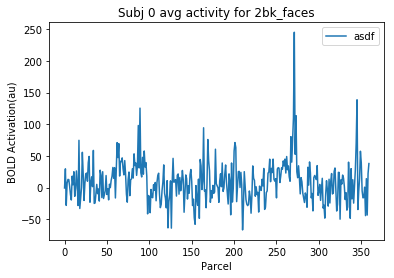

In [6]:
X = np.empty((N_SUBJECTS*2, N_PARCELS))

for subj in subjects:
  X[subj, :] = get_condition_bold(subj,'wm','2bk_faces', 0, ts_wm)
for subj in subjects:
  X[N_SUBJECTS + subj, :] = get_condition_bold(subj,'wm','2bk_tools', 0, ts_wm)

plt.figure()
ax=plt.plot(X[0,:], label='asdf') # 39 frames

plt.title(f'Subj {0} avg activity for 2bk_faces')
plt.xlabel('Parcel')
plt.ylabel('BOLD Activation(au)')
plt.legend()

plt.show()

In [5]:
y = np.concatenate(([0]*N_SUBJECTS,[1]*N_SUBJECTS))
y.shape

(678,)

(678, 360)


Text(0.5, 0, 'parcels')

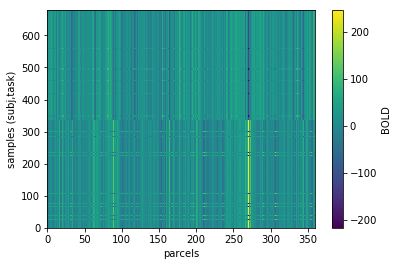

In [8]:
print(X.shape)
plt.pcolormesh(X)
plt.colorbar(label= "BOLD")
plt.ylabel('samples (subj,task)')
plt.xlabel('parcels')